# Cat_Dog_Classification
自分で用意したデータからデータセットを作成する手順の学習。イヌとネコの画像を見分ける２値分類問題

## 疑問点
* 自作データセットを作成し、訓練データと検証データに分ける場合、それぞれ別の前処理を行うにはどうすればいい？
* 各層のin_channelsやout_channelsは入力データのサイズによってどのように調整すればいい？

In [1]:
# データセットの確認
%ls data/cat_dog_dataset | head -10

cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.100.jpg
cat.101.jpg
cat.102.jpg
cat.103.jpg
cat.104.jpg
cat.105.jpg
cat.106.jpg


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
file_list = os.listdir("./data/cat_dog_dataset")

In [5]:
cat_files = [file_name for file_name in file_list if "cat" in file_name]
dog_files = [file_name for file_name in file_list if "dog" in file_name]

## 前処理

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # 画像のサイズがバラバラのため統一
    transforms.ToTensor()
])

## カスタムデータセットの確認

In [7]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, transform=None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
        
        if "dog" in self.file_list[0]:
            self.label = 1
        else:
            self.label = 0
            
    # 画像の枚数を返す
    def __len__(self):
        return len(self.file_list)

    # 前処理をしてデータを返す
    def __getitem__(self, idx):
        file_path = os.path.join(self.dir, self.file_list[idx])
        img = Image.open(file_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.label         

In [8]:
# ネコのデータセット
dir_path = "./data/cat_dog_dataset"
cat_dataset = CatDogDataset(cat_files, dir_path, transform=transform)

In [9]:
# イヌのデータセット
dir_path = "./data/cat_dog_dataset"
dog_dataset = CatDogDataset(dog_files, dir_path, transform=transform)

In [10]:
# データセットの結合
cat_dog_dataset = ConcatDataset([cat_dataset, dog_dataset])

## データの確認

In [11]:
# データローダーのインスタンス生成（ミニバッチを作成する）
#     batch_size: ミニバッチのサンプル数
data_loader = DataLoader(cat_dog_dataset, batch_size=32, shuffle=True)

# オブジェクトをイテレータに変換
data_iter = iter(data_loader)

# データを１つ読み込む
imgs, labels = next(data_iter)

# 複数の画像をグリッド上に並べた画像を作成
grid_imgs = torchvision.utils.make_grid(imgs[:24])

# numpyに変換
grid_imgs_arr = grid_imgs.numpy()

In [12]:
imgs[0].permute(1, 2, 0).cpu().numpy().shape

(256, 256, 3)

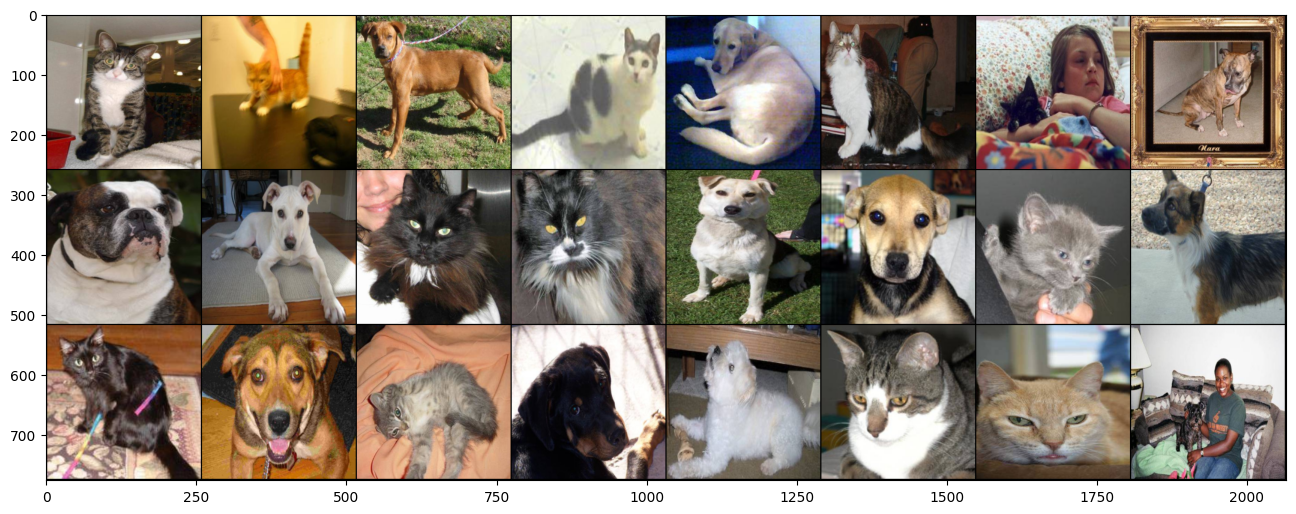

In [13]:
# 画像の出力
plt.figure(figsize=(16, 24))
plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))

In [14]:
n_samples = len(cat_dog_dataset) # n_samples is 60000
train_size = int(len(cat_dog_dataset) * 0.8) # train_size is 48000
val_size = n_samples - train_size # val_size is 48000

# shuffleしてから分割してくれる.
train_dataset, validation_dataset = torch.utils.data.random_split(cat_dog_dataset, [train_size, val_size])

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
class CNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )
    self.classifier = nn.Sequential(
        nn.Linear(in_features=32 * 32 * 128, out_features=num_classes),
        nn.Sigmoid()
    )
      
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [18]:
model = CNN(2) # クラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) #weight_decay: L2正則化

In [20]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in train_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    running_acc += torch.mean(pred.eq(labels).float())
    optimizer.step()
  running_loss /= len(train_dataloader)
  running_acc /= len(train_dataloader)
  losses.append(running_loss)
  accs.append(running_acc)
  #
  # validation loop
  #
  val_running_loss = 0.0
  val_running_acc = 0.0
  for val_imgs, val_labels in validation_dataloader:
    val_imgs = val_imgs.to(device)
    val_labels = val_labels.to(device)
    val_output = model(val_imgs)
    val_loss = criterion(val_output, val_labels)
    val_running_loss += val_loss.item()
    val_pred = torch.argmax(val_output, dim=1)
    val_running_acc += torch.mean(val_pred.eq(val_labels).float())
  val_running_loss /= len(validation_dataloader)
  val_running_acc /= len(validation_dataloader)
  val_losses.append(val_running_loss)
  val_accs.append(val_running_acc)
  print("epoch: {}, loss: {}, acc: {}, \
  val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 0.6990746955076853, acc: 0.484375,   val loss: 0.6969169974327087, val acc: 0.4283088445663452
epoch: 1, loss: 0.7048828601837158, acc: 0.5052083730697632,   val loss: 0.7117425501346588, val acc: 0.4283088445663452
epoch: 2, loss: 0.6912131607532501, acc: 0.5052083730697632,   val loss: 0.6968299150466919, val acc: 0.4283088445663452
epoch: 3, loss: 0.6928534309069315, acc: 0.484375,   val loss: 0.6948724985122681, val acc: 0.49724265933036804
epoch: 4, loss: 0.6916289329528809, acc: 0.515625,   val loss: 0.693838894367218, val acc: 0.48161765933036804
epoch: 5, loss: 0.6845851441224416, acc: 0.5833333730697632,   val loss: 0.731029748916626, val acc: 0.3658088445663452
epoch: 6, loss: 0.6713138322035471, acc: 0.578125,   val loss: 0.8139551877975464, val acc: 0.3501838445663452
epoch: 7, loss: 0.6376695434252421, acc: 0.65625,   val loss: 0.8551839292049408, val acc: 0.3033088445663452
epoch: 8, loss: 0.638979564110438, acc: 0.65625,   val loss: 0.8755543231964111, va

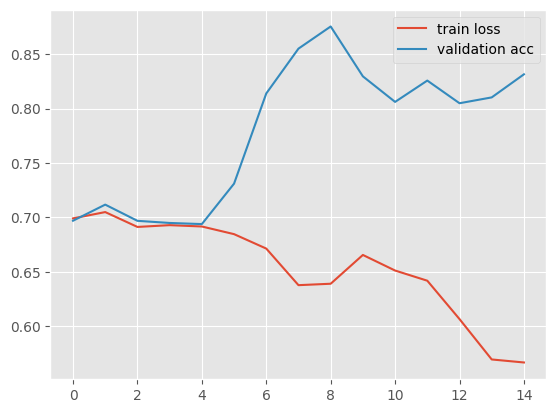

In [21]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation acc")
plt.legend()

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

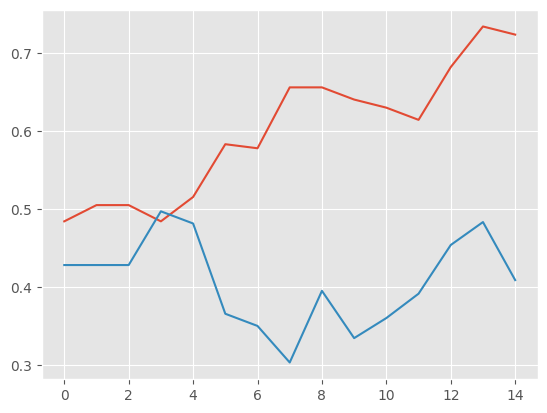

In [22]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend